In [3]:
from tensorboard.backend.event_processing import event_accumulator
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib import font_manager
%matplotlib inline
codebase = '/home/studio-lab-user/701-simplicity-bias'
root_dir = '/home/studio-lab-user/701-simplicity-bias/output/combined'
font = Path(os.path.join(codebase, 'notebooks', 'Times New Roman.ttf'))
font_manager.fontManager.addfont(font)

In [19]:
exps = []
ref_exps = []
def try_convert_to_number(x):
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return x

for dir in os.listdir(root_dir):
    if dir.startswith('.'): continue
    keywords = [try_convert_to_number(x) for x in dir.split('_')]
    keywords.append(os.path.join(root_dir, dir))
    if 'ref' in keywords:
        ref_exps.append(keywords)
    else:
        exps.append(keywords)
exps[:5]

[['5slabs',
  'sideprob',
  0.30625,
  '/home/studio-lab-user/701-simplicity-bias/output/combined/5slabs_sideprob_0.30625'],
 ['5slabs',
  'lineardim',
  30,
  'slabdim',
  20,
  '/home/studio-lab-user/701-simplicity-bias/output/combined/5slabs_lineardim_30_slabdim_20'],
 ['7slabs',
  'sideprob',
  0.28906,
  '/home/studio-lab-user/701-simplicity-bias/output/combined/7slabs_sideprob_0.28906'],
 ['7slabs',
  'sideprob',
  0.40625,
  '/home/studio-lab-user/701-simplicity-bias/output/combined/7slabs_sideprob_0.40625'],
 ['7slabs',
  'noiseprop',
  0.2,
  '/home/studio-lab-user/701-simplicity-bias/output/combined/7slabs_noiseprop_0.200']]

In [25]:
def load_tensorboard_logs(exps, keywords, x_index, name):
    exps = [exp for exp in exps if all(keyword in exp for keyword in keywords)]
    exps.sort(key=lambda tup: tup[x_index])
    if len(exps) == 0:
        raise ValueError('no such exps')
    xs = []
    train_acc = []
    val_acc = []
    srandom_acc = []
    scrandom_acc = []
    for exp in exps:
        xs.append(exp[x_index])
        event_name = [fname for fname in os.listdir(exp[-1]) if fname.startswith('events.')][0]
        ea = event_accumulator.EventAccumulator(os.path.join(exp[-1], event_name),
              size_guidance={
                  event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                  event_accumulator.IMAGES: 4,
                  event_accumulator.AUDIO: 4,
                  event_accumulator.SCALARS: 0,
                  event_accumulator.HISTOGRAMS: 1,
              })
        ea.Reload()
        train_acc.append(ea.Scalars('Train/Accuracy')[-1].value)
        val_acc.append(ea.Scalars('Val/Accuracy')[-1].value)
        srandom_acc.append(ea.Scalars('s_randomized/Accuracy')[-1].value)
        scrandom_acc.append(ea.Scalars('sc_randomized/Accuracy')[-1].value)
    xs = np.array(xs)
    train_acc = np.array(train_acc)
    val_acc = np.array(val_acc)
    srandom_acc = np.array(srandom_acc)
    scrandom_acc = np.array(scrandom_acc)
    np.savez(os.path.join(root_dir, name + '.npz'),
             xs, train_acc, val_acc, srandom_acc, scrandom_acc)
    return xs, train_acc, val_acc, srandom_acc, scrandom_acc

In [27]:
for nslabs in (5, 7):
    for exp_name, x_label in zip(('inputdim', 'sideprob', 'lineardim', 'noiseprop'),
                                 ('Input Dimensions', r'$\mathcal{P}^+$', 'Linear Dimensions', '$\zeta$')):
        keywords = ['{}slabs'.format(nslabs), exp_name]
        try:
            load_tensorboard_logs(exps, keywords, 2, '_'.join(keywords))
        except ValueError:
            print('no exps found for ', nslabs, exp_name)

no exps found for  5 noiseprop
no exps found for  7 lineardim


In [6]:
def draw_figure(exp_name, x_label, draw_srandom=True):
    xs, train_acc, val_acc, srandom_acc, scrandom_acc = np.load(os.path.join(root_dir, exp_name + '.npz')).values()
    fig = plt.figure(figsize=(4, 3))
    lw, alpha = 1.5, 0.8
    
    if 'sideprob' in exp_name:
        # This is a hack: our definition of side probability when collecting data is the probability of falling
        # in **each** side, but in the report it's of falling in **both** sides.
        xs *= 2
    
    plt.plot(xs, train_acc, label='Training Accuracy', linewidth=lw, alpha=alpha)
    plt.plot(xs, val_acc, label='Validation Accuracy', linewidth=lw, alpha=alpha)
    if draw_srandom:
        plt.plot(xs, srandom_acc, label='$S$-Randomized Accuracy', linewidth=lw, alpha=alpha)
        plt.plot(xs, scrandom_acc, label='$S^C$-Randomized Accuracy', linewidth=lw, alpha=alpha)
    plt.xlabel(x_label, font=font)
    plt.ylabel('Accuracy', font=font)
    plt.ylim([0.48, 1.02])
    plt.legend(prop={'family': 'Times New Roman'})
    ax = plt.gca()
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels:
        label.set_font(font)
    plt.savefig(os.path.join(root_dir, exp_name + '.pdf'), bbox_inches='tight', pad_inches=0, dpi=1200)
    plt.show()

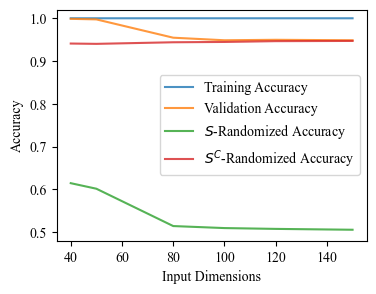

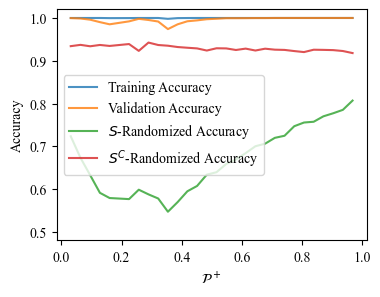

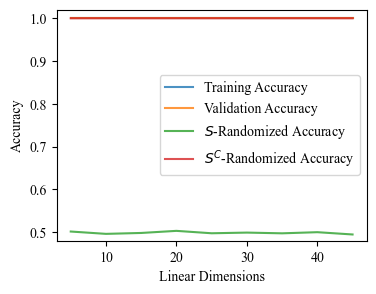

no exps found for  5 5slabs_noiseprop


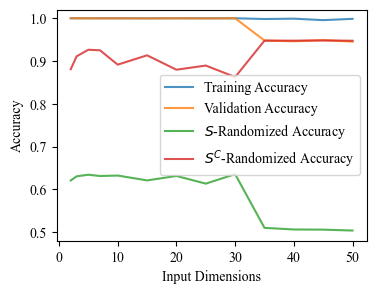

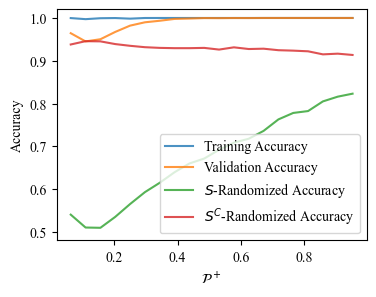

no exps found for  7 7slabs_lineardim


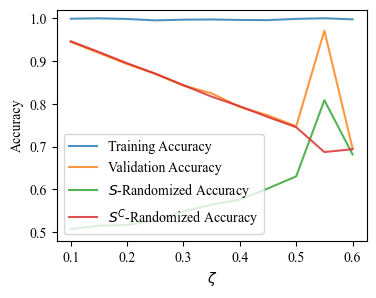

In [7]:
for nslabs in (5, 7):
    for exp_name, x_label in zip(('inputdim', 'sideprob', 'lineardim', 'noiseprop'),
                                 ('Input Dimensions', r'$\mathcal{P}^+$', 'Linear Dimensions', '$\zeta$')):
        name = '{}slabs_{}'.format(nslabs, exp_name)
        try:
            draw_figure(name, x_label, True)
        except FileNotFoundError:
            print('no exps found for ', nslabs, name)